# Prelude to creating performance curves

**CODE FOR CREATING PERFORMANCE CURVES HAS BEEN MOVED TO performance_curves.py in mm_interpret project.**

The outputs of `performance_curves.py` are:

* `siminout_path/{perf_curve_scenarios_suffix}_obflow06_metainputs_pc.csv` 
* `matrix_data_path/X_performance_curves_{perf_curve_scenarios_suffix}.csv`

For example: `exp11d_obflow06_metainputs_pc,csv`

Here's the code from start of `main` in `performance_curves.py`. Yes, that code should get moved into a CLI.

```python
        mm_experiment_suffix = "exp11"
        perf_curve_scenarios_suffix = "exp11d"
        # Path to scenario yaml file created by scenario_grid.py
        path_scenario_grid_yaml = Path("mm_use", f"scenario_grid_{perf_curve_scenarios_suffix}.yaml")
        path_scenario_csv = Path("mm_use", f"X_performance_curves_{perf_curve_scenarios_suffix}.csv")
        siminout_path = Path("data/siminout")
        matrix_data_path = Path("data")
```

The key input is the YAML file specifying the scenario grid. Also, note that performance curves may be created before the scenarios have been simulated. In fact, they may never get simulated unless we want to compare predicted outputs to simulation outputs.

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pathlib import Path
import pickle
import itertools
import yaml

In [26]:
%matplotlib inline

## Data reading and prep

In [27]:
experiment = "exp11"
data_path = Path("data")
siminout_path = Path("data", "siminout")
mm_use_path = Path("mm_use")

In [28]:
scenarios_io_df = pd.read_csv(Path(mm_use_path, "X_performance_curves_exp11d.csv"))
scenarios_io_df

,scenario,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp,c_sect_prob,cap_pp,load_ldr,rho_ldr,...,pred_ldr_occ_mean_q_nn,pred_ldr_occ_p95_q_nn,pred_prob_blockedby_pp_q_nn,pred_condmeantime_blockedby_pp_q_nn,pred_pp_occ_mean_basicq_lassocv,pred_pp_occ_p95_basicq_lassocv,pred_pp_occ_mean_onlyq_lm,pred_pp_occ_p95_onlyq_lm,pred_pp_occ_mean_noq_poly,pred_pp_occ_p95_noq_poly
0,1,0.3,2.4,12.0,16,54.0,0.25,75,3.6,0.225,...,411.607027,494.434365,-19.243712,138.565262,17.661674,24.238200,16.218513,23.001727,15.991022,30.793464
1,2,0.4,2.4,12.0,16,54.0,0.25,75,4.8,0.300,...,413.575950,496.552477,-19.340854,138.829025,22.836622,30.588476,21.609141,29.507878,21.458045,35.012732
2,3,0.5,2.4,12.0,16,54.0,0.25,75,6.0,0.375,...,415.438254,498.500961,-19.440727,139.104590,28.011571,36.764274,26.999768,35.852337,26.909092,39.512855
3,4,0.6,2.4,12.0,16,54.0,0.25,75,7.2,0.450,...,417.194875,500.284943,-19.541546,139.380456,33.186519,42.816135,32.390396,42.081942,32.344162,44.293833
4,5,0.7,2.4,12.0,16,54.0,0.25,75,8.4,0.525,...,418.817336,501.864116,-19.638981,139.639123,38.361468,48.774082,37.781023,48.224517,37.763255,49.355667
5,6,0.8,2.4,12.0,16,54.0,0.25,75,9.6,0.600,...,420.206005,503.134512,-19.719888,139.854782,43.536417,54.657678,43.171651,54.298188,43.166372,54.698355
6,7,0.9,2.4,12.0,16,54.0,0.25,75,10.8,0.675,...,421.287687,503.948980,-19.773795,140.000963,48.711365,60.480510,48.562278,60.315549,48.553511,60.321899
7,8,1.0,2.4,12.0,16,54.0,0.25,75,12.0,0.750,...,421.897139,504.075143,-19.799346,140.061419,53.886314,66.252472,53.952906,66.285768,53.924675,66.226298
8,9,1.1,2.4,12.0,16,54.0,0.25,75,13.2,0.825,...,421.323481,502.703823,-19.815429,140.001620,59.061262,71.981032,59.343534,72.215766,59.279861,72.411552
9,10,1.2,2.4,12.0,16,54.0,0.25,75,14.4,0.900,...,417.098972,497.079948,-19.884993,139.630389,64.236211,77.671992,64.734161,78.110920,64.619070,78.877661


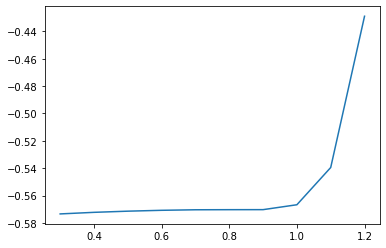

In [29]:
x = scenarios_io_df['arrival_rate']
y = scenarios_io_df['pred_prob_blockedby_pp_q_lm']
plt.plot(x, y)

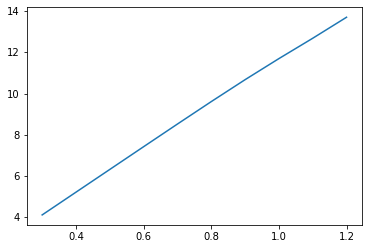

In [30]:
x = scenarios_io_df['arrival_rate']
y = scenarios_io_df['pred_ldr_occ_mean_q_lassocv']
plt.plot(x, y)

## Comparing predicted perf curves to simulation results

* I created a scenario input file: `exp11c_obflow06_metainputs.csv`.
* Create a run settings file `input/exp11c_obflow06_settings.yaml`
* Edit (until I create a CLI) `obsimpy.create_configs.py` by setting experiment suffix. This then creates all the necessary path related variables. Make sure to create the new subdirs in logs and stats with same name as experiment suffix.
* Run `obsimpy.create_configs.py` that takes the scenario input file and run settings as input and then creates:
    - one obsimpy yaml config file for each scenario row
    - a bash script to run each simulation scenario and then runs `obflow_6_output.py` to post process the logs and stats  
    - results in `scenario_siminout_{perf_curve_scenarios_suffix}.csv`
    - we can import this csv file to provide the actual simulation based estimates of all the performance measures.





In [31]:
scenario_siminout_exp11c_df = pd.read_csv(Path(siminout_path, 'exp11c', 'scenario_siminout_exp11c.csv'), 
                                         index_col=0)

scenario_siminout_exp11d_df = pd.read_csv(Path(siminout_path, 'exp11d', 'scenario_siminout_exp11d.csv'), 
                                         index_col=0)

X_performance_curves_exp11c_df = pd.read_csv(Path(mm_use_path, 'X_performance_curves_exp11c.csv'), 
                                         index_col=0)

X_performance_curves_exp11d_df = pd.read_csv(Path(mm_use_path, 'X_performance_curves_exp11d.csv'), 
                                         index_col=0)



In [32]:
scenario_siminout_exp11c_df.head()

,arrival_rate,mean_los_obs,num_erlang_stages_obs,mean_los_ldr,num_erlang_stages_ldr,mean_los_csect,num_erlang_stages_csect,mean_los_pp_noc,mean_los_pp_c,num_erlang_stages_pp,...,occ_mean_p95_obs,occ_mean_p95_ldr,occ_mean_p95_csect,occ_mean_p95_pp,prob_blockedby_ldr,condmeantime_blockedby_ldr,condp95time_blockedby_ldr,prob_blockedby_pp,condmeantime_blockedby_pp,condp95time_blockedby_pp
scenario,,,,,,,,,,,,,,,,,,,,,
1,0.3,2.4,1,12,2,1,4,48,72,8,...,2.0,7.000000,1.0,23.066667,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.4,2.4,1,12,2,1,4,48,72,8,...,3.0,8.933333,1.0,29.466667,0.000040,0.210431,0.284092,0.0,0.0,0.0
3,0.5,2.4,1,12,2,1,4,48,72,8,...,3.0,10.066667,1.0,35.866667,0.000548,0.780137,1.628265,0.0,0.0,0.0
4,0.6,2.4,1,12,2,1,4,48,72,8,...,4.0,12.000000,1.0,41.966667,0.003070,1.101658,2.888380,0.0,0.0,0.0
5,0.7,2.4,1,12,2,1,4,48,72,8,...,4.0,13.266667,1.0,48.033333,0.012303,1.198448,3.238090,0.0,0.0,0.0


In [33]:
X_performance_curves_exp11c_df.head()

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp,c_sect_prob,cap_pp,load_ldr,rho_ldr,load_pp,...,pred_ldr_occ_mean_q_nn,pred_ldr_occ_p95_q_nn,pred_prob_blockedby_pp_q_nn,pred_condmeantime_blockedby_pp_q_nn,pred_pp_occ_mean_basicq_lassocv,pred_pp_occ_p95_basicq_lassocv,pred_pp_occ_mean_onlyq_lm,pred_pp_occ_p95_onlyq_lm,pred_pp_occ_mean_noq_poly,pred_pp_occ_p95_noq_poly
scenario,,,,,,,,,,,,,,,,,,,,,
1,0.3,2.4,12.0,16,54.0,0.25,75,3.6,0.225,16.2,...,55.138754,69.531609,-2.733292,18.397908,17.661674,24.238200,16.218513,23.001727,15.991022,30.793464
2,0.4,2.4,12.0,16,54.0,0.25,75,4.8,0.300,21.6,...,57.202930,71.479409,-2.815337,18.535531,22.836622,30.588476,21.609141,29.507878,21.458045,35.012732
3,0.5,2.4,12.0,16,54.0,0.25,75,6.0,0.375,27.0,...,59.146784,73.312957,-2.898960,18.829077,28.011571,36.764274,26.999768,35.852337,26.909092,39.512855
4,0.6,2.4,12.0,16,54.0,0.25,75,7.2,0.450,32.4,...,61.063134,75.120932,-2.994280,19.123845,33.186519,42.816135,32.390396,42.081942,32.344162,44.293833
5,0.7,2.4,12.0,16,54.0,0.25,75,8.4,0.525,37.8,...,62.958647,76.743393,-3.100696,19.400871,38.361468,48.774082,37.781023,48.224517,37.763255,49.355667


Now merge the performance curves dataframe (which contains input vars and predictions) with the simulation inputs and outputs. Note that duplicate column names on the siminout table get `_sim` appended.

In [34]:
#performance_curves_exp11b_simout_df = X_performance_curves_exp11b_df.merge(scenario_siminout_exp11b_df, on='scenario', suffixes=[None, '_sim'])
performance_curves_exp11c_simout_df = X_performance_curves_exp11c_df.merge(scenario_siminout_exp11c_df, on='scenario', suffixes=[None, '_sim'])
performance_curves_exp11d_simout_df = X_performance_curves_exp11d_df.merge(scenario_siminout_exp11d_df, on='scenario', suffixes=[None, '_sim'])

In [35]:
for c in performance_curves_exp11c_simout_df.columns:
    print(c)

arrival_rate
mean_los_obs
mean_los_ldr
cap_ldr
mean_los_pp
c_sect_prob
cap_pp
load_ldr
rho_ldr
load_pp
rho_pp
prob_blockedby_pp_approx
condmeantime_blockedby_pp_approx
prob_blockedby_ldr_approx
condmeantime_blockedby_ldr_approx
pp_cv2_svctime
ldr_eff_load
ldr_eff_sqrtload
ldr_effmean_svctime_approx
sqrt_load_ldr
sqrt_load_pp
pred_ldr_occ_mean_q_lassocv
pred_ldr_occ_p95_q_lassocv
pred_prob_blockedby_pp_q_lassocv
pred_condmeantime_blockedby_pp_q_lassocv
pred_ldr_occ_mean_q_lm
pred_ldr_occ_p95_q_lm
pred_prob_blockedby_pp_q_lm
pred_condmeantime_blockedby_pp_q_lm
pred_ldr_occ_mean_onlyq_lm
pred_ldr_occ_p95_onlyq_lm
pred_prob_blockedby_pp_onlyq_lm
pred_condmeantime_blockedby_pp_onlyq_lm
pred_ldr_occ_mean_noq_lm
pred_ldr_occ_p95_noq_lm
pred_prob_blockedby_pp_noq_lm
pred_condmeantime_blockedby_pp_noq_lm
pred_ldr_occ_mean_noq_poly
pred_ldr_occ_p95_noq_poly
pred_prob_blockedby_pp_noq_poly
pred_condmeantime_blockedby_pp_noq_poly
pred_ldr_occ_mean_basicq_poly
pred_ldr_occ_p95_basicq_poly
pred_prob

## Make plots

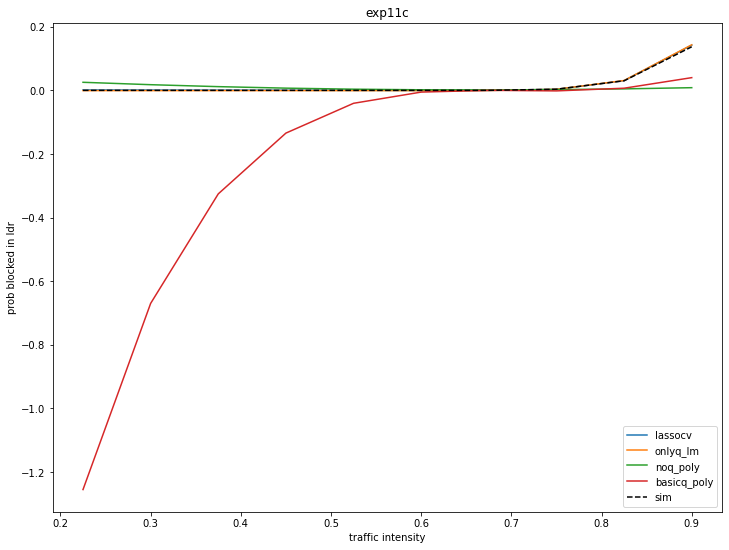

In [47]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_noq_poly']
y4 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_basicq_poly']
y5 = performance_curves_exp11c_simout_df['prob_blockedby_pp']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, 'k--', label='sim')
plt.title("exp11c")
plt.xlabel('traffic intensity')
plt.ylabel('prob blocked in ldr')
plt.legend()
plt.show()

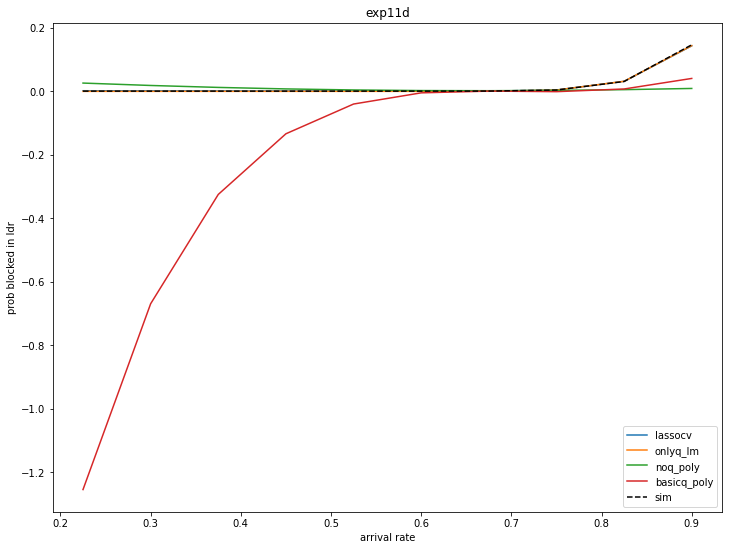

In [20]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11d_simout_df['rho_ldr']
y1 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_q_lassocv']
y2 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_onlyq_lm']
y3 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_noq_poly']
y4 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_basicq_poly']
y5 = performance_curves_exp11d_simout_df['prob_blockedby_pp']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, 'k--', label='sim')
plt.title("exp11d")
plt.xlabel('traffic intensity')
plt.ylabel('prob blocked in ldr')
plt.legend()
plt.show()

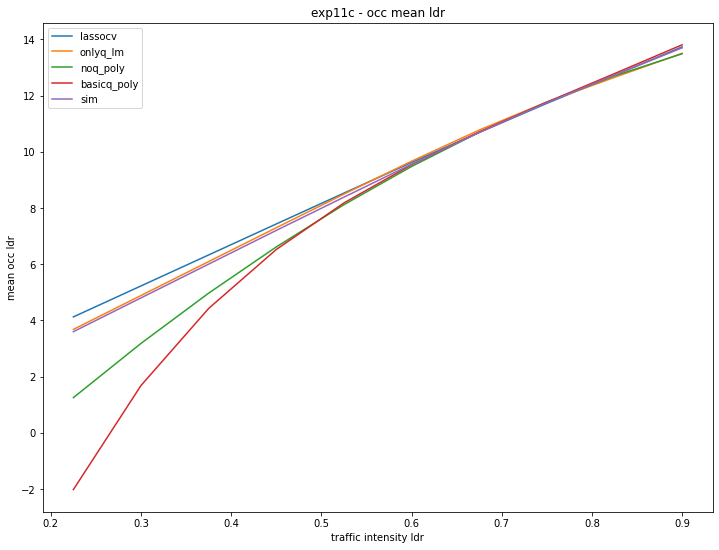

In [37]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_noq_poly']
y4 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_basicq_poly']
y5 = performance_curves_exp11c_simout_df['occ_mean_mean_ldr']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='sim')
plt.title("exp11c - occ mean ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('mean occ ldr')
plt.legend()
plt.show()

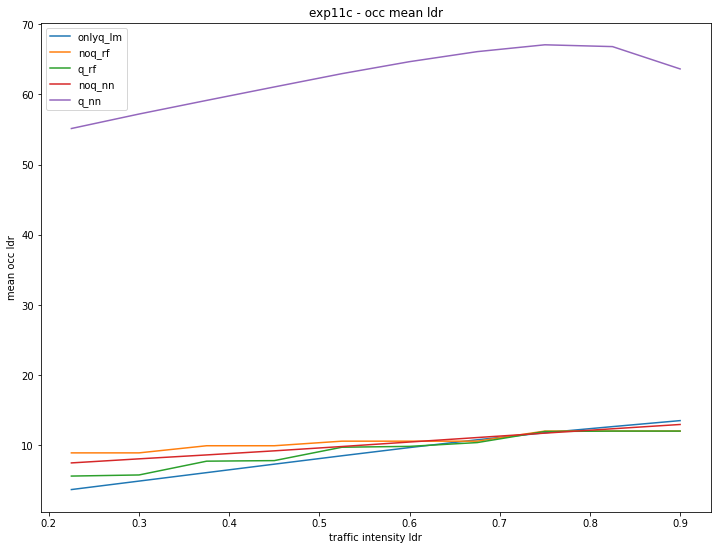

In [42]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_noq_rf']
y4 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_rf']
y5 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_noq_nn']
y6 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_nn']
y7 = performance_curves_exp11c_simout_df['occ_mean_mean_ldr']
#plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_rf')
plt.plot(x, y4, label='q_rf')
plt.plot(x, y5, label='noq_nn')
plt.plot(x, y6, label='q_nn')
#plt.plot(x, y7, label='sim')
plt.title("exp11c - occ mean ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('mean occ ldr')
plt.legend()
plt.show()

I've confirmed that the nn's are fit using a Pipeline which includes StandardScaler as first step. Saved model object IS the pipeline. Do predicting on new data should result in the StandardScaler being applied first to the new new data and then the scaled data fed to the fit neural net. It's just hard to believe the predictions could be this bad. However, lassocv also used scaled data with a pipeline and it predicts beautifully.

**TODO: Isolate a single neural net example to prove it really does fit this bad.**

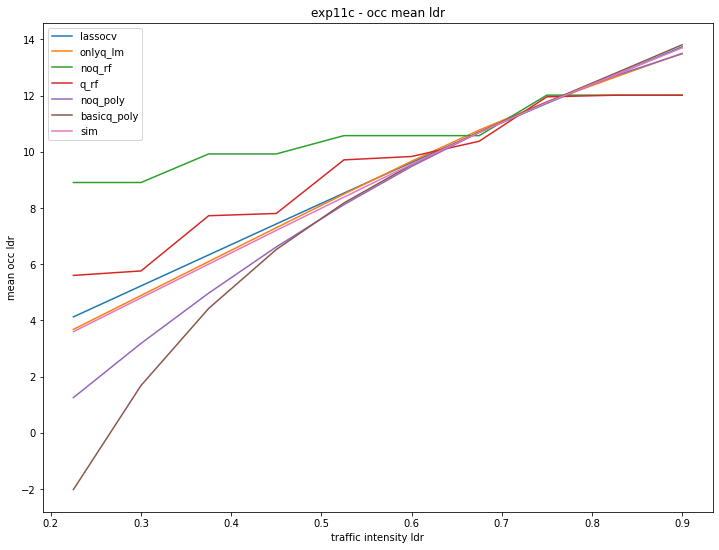

In [45]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_noq_rf']
y4 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_rf']
y5 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_noq_poly']
y6 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_basicq_poly']
y7 = performance_curves_exp11c_simout_df['occ_mean_mean_ldr']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_rf')
plt.plot(x, y4, label='q_rf')
plt.plot(x, y5, label='noq_poly')
plt.plot(x, y6, label='basicq_poly')
plt.plot(x, y7, label='sim')
plt.title("exp11c - occ mean ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('mean occ ldr')
plt.legend()
plt.show()

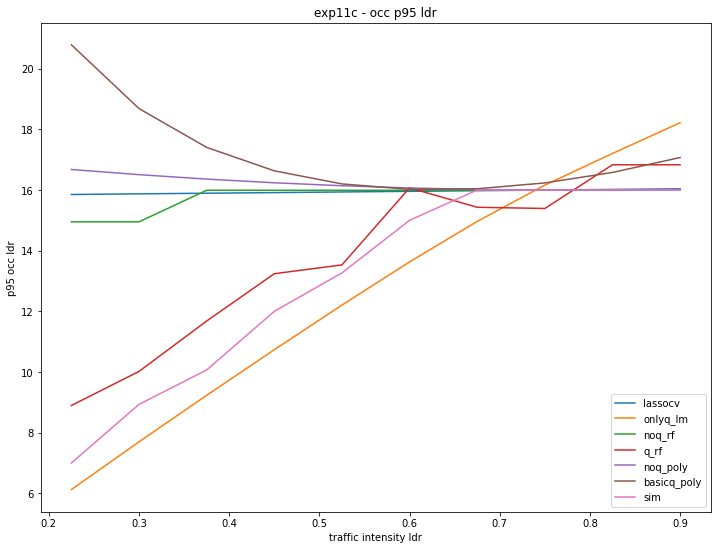

In [48]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_noq_rf']
y4 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_q_rf']
y5 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_noq_poly']
y6 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_basicq_poly']
y7 = performance_curves_exp11c_simout_df['occ_mean_p95_ldr']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_rf')
plt.plot(x, y4, label='q_rf')
plt.plot(x, y5, label='noq_poly')
plt.plot(x, y6, label='basicq_poly')
plt.plot(x, y7, label='sim')
plt.title("exp11c - occ p95 ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('p95 occ ldr')
plt.legend()
plt.show()

In [49]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_pp']
y1 = performance_curves_exp11c_simout_df['pred_prob_blockedby_ldr_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_prob_blockedby_ldr_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_prob_blockedby_ldr_noq_poly']
y4 = performance_curves_exp11c_simout_df['pred_prob_blockedby_ldr_basicq_poly']
y5 = performance_curves_exp11c_simout_df['prob_blockedby_ldr']
plt.plot(x, y1, label='lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, 'k--', label='sim')
plt.title("exp11c")
plt.xlabel('traffic intensity')
plt.ylabel('prob blocked in ldr')
plt.legend()
plt.show()

KeyError: 'pred_prob_blockedby_ldr_q_lassocv'

<Figure size 864x648 with 0 Axes>

In [ ]:
ldr_results['ldr_occ_p95_q_lassocv_results'].keys()

In [ ]:
ldr_results['ldr_occ_p95_q_lassocv_results']['coeffs_df'].transpose()

From below, looks like the coefficient plot is on the scaled coefficients. Does this have something to do with scaling? Is the model using scaled or unscaled coefficients? Does the model know it's been scaled? How does it treat new data for predictions?

In [ ]:
ldr_results['ldr_occ_p95_q_lassocv_results']['scaled_coeffs_df'].transpose()

In [ ]:
ldr_results['ldr_occ_p95_q_lassocv_results']['predictions']

In [ ]:
ldr_results['ldr_occ_p95_q_lm_results']['coeffs_df'].transpose()

In [ ]:
ldr_results['ldr_occ_p95_q_lassocv_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_q_lassocv_coeffs.csv')
ldr_results['ldr_occ_p95_q_lm_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_q_lm_coeffs.csv')
ldr_results['ldr_occ_p95_onlyq_lm_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_onlyq_lm_coeffs.csv')
ldr_results['ldr_occ_p95_q_poly_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_q_poly.csv')
ldr_results['ldr_occ_p95_noq_poly_results']['coeffs_df'].to_csv('output/coeffs/ldr_occ_p95_noq_poly.csv')

In [ ]:
x = scenarios_io_df['rho_ldr']
y1a = X_performance_curves_df['pred_ldr_occ_p95_q_lm']
y1b = X_performance_curves_df['pred_ldr_occ_p95_q_lassocv']
y2 = X_performance_curves_df['pred_ldr_occ_p95_onlyq_lm']
y3a = X_performance_curves_df['pred_ldr_occ_p95_noq_poly']
y3b = X_performance_curves_df['pred_ldr_occ_p95_noq_lm']
y4 = scenarios_io_df['occ_mean_p95_ldr']
plt.plot(x, y1a, label='q_lm')
plt.plot(x, y1b, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3a, label='noq_poly')
plt.plot(x, y3a, label='noq_lm')
plt.plot(x, y4, label='sim')
plt.xlabel('traffic intensity ldr')
plt.ylabel('p95 occ ldr')
plt.legend()
plt.show()

Let's add the noq curve that would have been generated. This should be a good test of the "so what?" question. Is it worth it to expend the extra modeling effort to include queueing terms. In addition to prob blocked in ldr, let's do curves for:

* occ mean ldr
* occ p95 ldr
* cond mean wait time in ldr
* occ mean pp
* occ p95 pp



So, why then do nn, rf and svr perform so poorly when all they need to do is discover a single variable regression model (for mean occ using load) or a almost as simple load + z * sqrt(load) model?

## Variable importance in the RF models
This might be interesting to look at. Does it jive with our queueing knowledge?

## Boosted regression trees
Do algos exist in sklearn for these?

## Scratch pad

In [ ]:
'a' + 'b'

In [ ]:
max(0, -2)

In [ ]:
np.arange(.3, 1.4, 0.1).tolist()

In [ ]:
mm_experiment_suffix = "exp11"
perf_curve_scenarios_suffix = "exp11d"
path_scenario_grid_yaml = Path("mm_use", f"scenario_grid_{perf_curve_scenarios_suffix}.yaml")
path_scenario_df = Path("mm_use", f"X_performance_curves_{perf_curve_scenarios_suffix}.csv")
raw_data_path = Path("data/siminout")

with open(path_scenario_grid_yaml, "r") as stream:
    try:
        scenario_grid = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

print(scenario_grid)

In [ ]:
#pd.DataFrame(scenario_grid)

In [ ]:
for t in itertools.product([0, 1], [2, 4]):
    print(t)

In [ ]:
for t in itertools.product(*[[0, 1], [2, 4]]):
    print(t)

In [ ]:
[value for key, value in scenario_grid.items()]

In [ ]:
for t in itertools.product(*[value for key, value in scenario_grid.items()]):
    print(t)

In [ ]:
input_scenarios =  [scn for scn in itertools.product(*[value for key, value in scenario_grid.items()])]
input_scenarios

In [ ]:
input_scenarios = [scn for scn in itertools.product(
    arrival_rate, mean_los_obs, cap_obs, mean_los_ldr, mean_los_csect, cap_ldr,
    mean_los_pp_noc, mean_los_pp_c, c_sect_prob, cap_pp,
    num_erlang_stages_obs, num_erlang_stages_ldr, num_erlang_stages_pp, num_erlang_stages_csect)]

In [ ]:
cols = ['arrival_rate', 'mean_los_obs', 'cap_obs', 'mean_los_ldr', 'mean_los_csect', 'cap_ldr',
        'mean_los_pp_noc', 'mean_los_pp_c', 'c_sect_prob', 'cap_pp',
        'num_erlang_stages_obs', 'num_erlang_stages_ldr',
        'num_erlang_stages_pp', 'num_erlang_stages_csect']